In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [2]:
DATASET_DIR = r'C:\Users\91877\Mini Project\dataset'
FIRE_DIR = os.path.join(DATASET_DIR, 'fire')
NOFIRE_DIR = os.path.join(DATASET_DIR, 'nofire')

IMG_SIZE = 128
FRAMES_PER_VIDEO = 15
AUGMENTATION = True  # Turn on data augmentation


In [3]:
def extract_frames(video_path, max_frames=FRAMES_PER_VIDEO, augment=False):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(1, total_frames // max_frames)

    for i in range(max_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        if augment:
            if random.random() < 0.5:
                frame = cv2.flip(frame, 1)
        frames.append(frame)

    cap.release()
    return frames


In [4]:
X = []
y = []

for file in os.listdir(FIRE_DIR):
    if file.endswith(".mp4"):
        frames = extract_frames(os.path.join(FIRE_DIR, file), augment=AUGMENTATION)
        X.extend(frames)
        y.extend([1]*len(frames))

for file in os.listdir(NOFIRE_DIR):
    if file.endswith(".mp4"):
        frames = extract_frames(os.path.join(NOFIRE_DIR, file), augment=AUGMENTATION)
        X.extend(frames)
        y.extend([0]*len(frames))

X = np.array(X)
y = np.array(y)
print("Dataset loaded:", X.shape, y.shape)


Dataset loaded: (315, 128, 128, 3) (315,)


In [5]:
X = X.astype('float32') / 255.0
y_cat = to_categorical(y, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)
print("Train/Test split:", X_train.shape, X_test.shape)


Train/Test split: (252, 128, 128, 3) (63, 128, 128, 3)


In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze pre-trained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_test, y_test)
)


Epoch 1/15


c:\Users\91877\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.4454 - loss: 1.3531 - val_accuracy: 0.2063 - val_loss: 1.2509
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.4454 - loss: 1.3531 - val_accuracy: 0.2063 - val_loss: 1.2509
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.4454 - loss: 1.3531 - val_accuracy: 0.2063 - val_loss: 1.2509
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.4677 - loss: 1.2066 - val_accuracy: 0.2540 - val_loss: 1.1301
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.4677 - loss: 1.2066 - val_accuracy: 0.2540 - val_loss: 1.1301
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.4677 - loss: 1.2066 - val_accuracy: 0.2540 - val_loss: 1.1301
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4717 - loss: 1.1981 - val_accuracy: 0.3651 - val_loss: 1.0127
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4717 - loss: 1.1981 - val_accuracy: 0.3651 - val_loss: 1.0127
Epo

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"📊 Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9578 - loss: 0.2849
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9578 - loss: 0.2849
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9578 - loss: 0.2849
📊 Test Accuracy: 0.9524, Loss: 0.2888
📊 Test Accuracy: 0.9524, Loss: 0.2888
📊 Test Accuracy: 0.9524, Loss: 0.2888


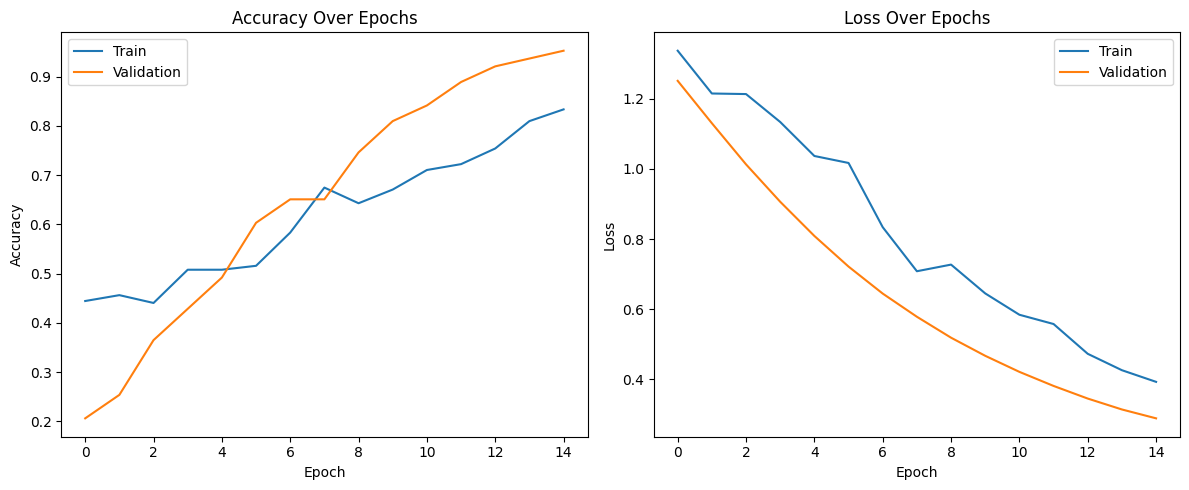

In [9]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('../../static/charts/accuracy_loss.png')

plt.show()



In [10]:

def save_graph(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.savefig("static/plots/accuracy_loss.png")   # ✅ save inside static/plots
    plt.close()


In [11]:
def predict_video(video_path):
    frames = extract_frames(video_path, max_frames=FRAMES_PER_VIDEO)
    frames = np.array(frames).astype('float32') / 255.0
    preds = model.predict(frames)
    avg_pred = np.mean(preds, axis=0)
    label = '🔥 FIRE' if np.argmax(avg_pred) == 1 else '🌲 NO FIRE'
    print(f"Prediction: {label} ({avg_pred})")
    return label


In [12]:
from IPython.display import HTML, display

def show_video(video_path):
    try:
        rel_path = os.path.relpath(video_path, start=os.getcwd())
        rel_path = rel_path.replace('\\', '/')
        return HTML(f"""
            <video width="400" controls>
                <source src="{rel_path}" type="video/mp4">
                Your browser does not support the video tag.
            </video>
        """)
    except Exception as e:
        print(f"❌ Error displaying video: {e}")


In [13]:
video_path = r'C:\Users\91877\Mini Project\dataset\fire\fire8.mp4'  # Or nofire video
predict_video(video_path)
display(show_video(video_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
Prediction: 🌲 NO FIRE ([0.53423274 0.46576732])
Prediction: 🌲 NO FIRE ([0.53423274 0.46576732])
Prediction: 🌲 NO FIRE ([0.53423274 0.46576732])


In [14]:
def predict_video(video_path):
    frames = extract_frames(video_path, max_frames=FRAMES_PER_VIDEO)
    frames = np.array(frames).astype('float32') / 255.0
    preds = model.predict(frames)
    avg_pred = np.mean(preds, axis=0)
    label = '🔥 FIRE' if np.argmax(avg_pred) == 1 else '🌲 NO FIRE'
    print(f"Prediction: {label} ({avg_pred})")
    return label


In [15]:
from IPython.display import HTML, display

def show_video(video_path):
    try:
        rel_path = os.path.relpath(video_path, start=os.getcwd())
        rel_path = rel_path.replace('\\', '/')
        return HTML(f"""
            <video width="400" controls>
                <source src="{rel_path}" type="video/mp4">
                Your browser does not support the video tag.
            </video>
        """)
    except Exception as e:
        print(f"❌ Error displaying video: {e}")


In [16]:
video_path = r'C:\Users\91877\Mini Project\dataset\nofire\nofire1.mp4'  # Or nofire video
predict_video(video_path)
display(show_video(video_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Prediction: 🌲 NO FIRE ([0.8918582  0.10814173])
Prediction: 🌲 NO FIRE ([0.8918582  0.10814173])
Prediction: 🌲 NO FIRE ([0.8918582  0.10814173])


In [17]:
import os
os.makedirs("static/charts", exist_ok=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


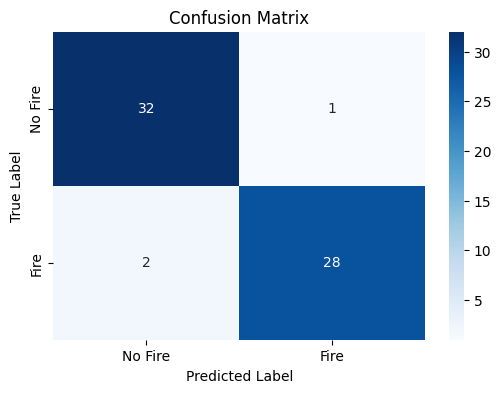

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.94      0.97      0.96        33
        Fire       0.97      0.93      0.95        30

    accuracy                           0.95        63
   macro avg       0.95      0.95      0.95        63
weighted avg       0.95      0.95      0.95        63



In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Convert predictions and labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('static/charts/confusion_matrix.png')
plt.savefig('../../static/charts/confusion_matrix.png')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Fire', 'Fire']))


In [19]:
def save_confusion_matrix(cm, labels, filename="static/charts/confusion_matrix.png"):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

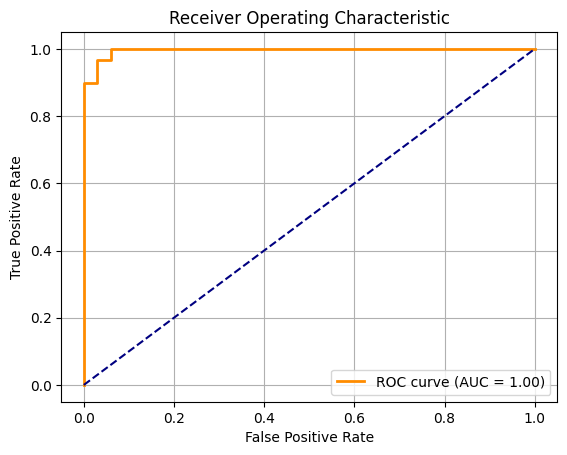

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

fpr, tpr, _ = roc_curve(y_test[:,1], y_pred_probs[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [21]:
from tensorflow.keras.models import save_model

model_path = "forest_fire_model_mobilenetv2.h5"
save_model(model, model_path)
print(f"✅ Model saved successfully at: {model_path}")


✅ Model saved successfully at: forest_fire_model_mobilenetv2.h5


c:\Users\91877\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


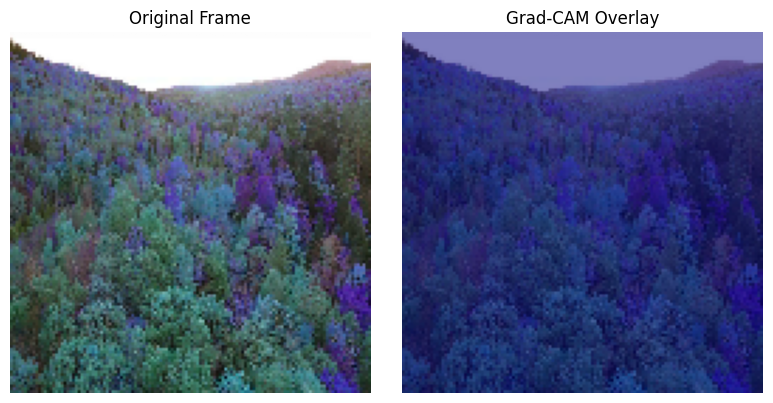

In [22]:
import tensorflow as tf

def get_grad_cam(img_array, model, layer_name='Conv_1'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    img_input = np.expand_dims(img_array, axis=0)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        loss = predictions[:, 1]  # for fire class

    grads = tape.gradient(loss, conv_outputs)[0]  # Shape: (H, W, Channels)
    weights = tf.reduce_mean(grads, axis=(0, 1))  # Channel-wise mean
    cam = np.zeros(conv_outputs.shape[1:3], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[0, :, :, i]

    cam = np.maximum(cam, 0)  # ReLU
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))  # No .numpy() needed
    cam = cam - np.min(cam)
    cam = cam / (np.max(cam) + 1e-8)  # Avoid division by zero
    return cam

# Visualize for one image from test set
sample_img = X_test[0]
cam = get_grad_cam(sample_img, model)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Frame")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_img)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

def batch_predict(folder_path):
    results = []
    for file in os.listdir(folder_path):
        if file.endswith('.mp4'):
            path = os.path.join(folder_path, file)
            label = predict_video(path)
            results.append({"video": file, "prediction": label})
    
    df = pd.DataFrame(results)
    df.to_csv("predicted_results.csv", index=False)
    print("✅ Batch predictions saved to predicted_results.csv")
    return df

# Example usage
batch_predict(FIRE_DIR)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Prediction: 🔥 FIRE ([0.14647935 0.85352063])
Prediction: 🔥 FIRE ([0.14647935 0.85352063])
Prediction: 🔥 FIRE ([0.14647935 0.85352063])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction: 🔥 FIRE ([0.23605917 0.7639409 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction: 🔥 FIRE ([0.23605917 0.7639409 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction: 🔥 FIRE ([0.23605917 0.7639409 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction: 🌲 NO FIRE ([0.5580818 0.4419182])Prediction: 🌲 NO FIRE ([0.5580818 0.4419182])Prediction: 🌲 NO FIRE ([0.5580818 0.4419182])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Prediction: 🔥 FIRE ([0.27550885 0.7244912 ])
Prediction: 🔥 FIRE ([0.27550885 0.7244912 ])
Prediction: 🔥 FIRE ([0.27550885 0.7244912 ])
1

,video,prediction
0,fire1.mp4,🔥 FIRE
1,fire10.mp4,🔥 FIRE
2,fire11.mp4,🌲 NO FIRE
3,fire2.mp4,🔥 FIRE
4,fire3.mp4,🔥 FIRE
5,fire4.mp4,🔥 FIRE
6,fire5.mp4,🔥 FIRE
7,fire7.mp4,🔥 FIRE
8,fire8.mp4,🌲 NO FIRE
9,fire9.mp4,🔥 FIRE


In [24]:
def apply_grad_cam_to_video(video_path, output_dir="gradcam_outputs", max_frames=FRAMES_PER_VIDEO):
    os.makedirs(output_dir, exist_ok=True)
    frames = extract_frames(video_path, max_frames=max_frames)
    heatmapped_frames = []

    for idx, frame in enumerate(frames):
        cam = get_grad_cam(frame, model)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(np.uint8(frame * 255), 0.6, heatmap, 0.4, 0)
        filename = os.path.join(output_dir, f"frame_{idx}.jpg")
        cv2.imwrite(filename, overlay)
        heatmapped_frames.append(overlay)

    print(f"✅ Grad-CAM frames saved to: {output_dir}")
    return heatmapped_frames

# 🔍 Example usage:
video_path = r'C:\Users\91877\Mini Project\dataset\fire\fire3.mp4'
apply_grad_cam_to_video(video_path)


c:\Users\91877\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


✅ Grad-CAM frames saved to: gradcam_outputs


[array([[[202, 149, 131],
         [204, 149, 129],
         [203, 148, 128],
         ...,
         [255, 184, 146],
         [255, 184, 146],
         [255, 184, 146]],
 
        [[202, 148, 131],
         [203, 148, 128],
         [203, 148, 128],
         ...,
         [255, 184, 146],
         [255, 184, 146],
         [255, 184, 146]],
 
        [[203, 148, 127],
         [203, 148, 127],
         [201, 146, 125],
         ...,
         [255, 184, 146],
         [255, 184, 146],
         [255, 184, 146]],
 
        ...,
 
        [[204, 153, 153],
         [204,   0, 152],
         [204,   0, 152],
         ...,
         [  0, 153, 202],
         [  0, 153, 202],
         [  0, 153, 202]],
 
        [[204, 153, 153],
         [204,   0, 152],
         [204,   0, 152],
         ...,
         [  0, 153, 202],
         [  0, 153, 202],
         [  0, 153, 202]],
 
        [[204, 153, 153],
         [204,   0, 152],
         [204,   0, 152],
         ...,
         [  0, 152, 201],
  

In [25]:
import glob

def create_video_from_frames(output_dir="gradcam_outputs", output_file="gradcam_result.mp4"):
    frame_files = sorted(glob.glob(os.path.join(output_dir, "frame_*.jpg")))
    if not frame_files:
        print("❌ No frames found to create video.")
        return

    # Load first frame to get dimensions
    frame = cv2.imread(frame_files[0])
    height, width, _ = frame.shape
    video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))

    for file in frame_files:
        frame = cv2.imread(file)
        video.write(frame)

    video.release()
    print(f"🎥 Grad-CAM video saved as: {output_file}")

# 🔁 Example
create_video_from_frames()


🎥 Grad-CAM video saved as: gradcam_result.mp4


In [26]:
def batch_predict_with_gradcam(folder_path, output_csv="batch_gradcam_results.csv"):
    results = []

    for file in os.listdir(folder_path):
        if file.endswith('.mp4'):
            path = os.path.join(folder_path, file)
            label = predict_video(path)
            apply_grad_cam_to_video(path, output_dir=f"gradcam_outputs/{os.path.splitext(file)[0]}")
            results.append({'video': file, 'prediction': label})

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved batch results to {output_csv}")
    return df

# Run on your dataset
batch_predict_with_gradcam(FIRE_DIR)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction: 🔥 FIRE ([0.14647935 0.85352063])
Prediction: 🔥 FIRE ([0.14647935 0.85352063])
Prediction: 🔥 FIRE ([0.14647935 0.85352063])
✅ Grad-CAM frames saved to: gradcam_outputs/fire1
✅ Grad-CAM frames saved to: gradcam_outputs/fire1
✅ Grad-CAM frames saved to: gradcam_outputs/fire1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Prediction: 🔥 FIRE ([0.23605917 0.7639409 ])
Prediction: 🔥 FIRE ([0.23605917 0.7639409 ])
Prediction: 🔥 FIRE ([0.23605917 0.7639409 ])
✅ Grad-CAM frames saved to: gradcam_outputs/fire10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
✅ Grad-CAM frames saved to: gradcam_outputs/fire10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
✅ Grad-CAM frames saved to: gradcam_outputs/fire10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction: 🌲 NO FIRE ([0.5580818 0.4419182])
Prediction: 🌲 NO FIRE ([0.5580818 0.441

,video,prediction
0,fire1.mp4,🔥 FIRE
1,fire10.mp4,🔥 FIRE
2,fire11.mp4,🌲 NO FIRE
3,fire2.mp4,🔥 FIRE
4,fire3.mp4,🔥 FIRE
5,fire4.mp4,🔥 FIRE
6,fire5.mp4,🔥 FIRE
7,fire7.mp4,🔥 FIRE
8,fire8.mp4,🌲 NO FIRE
9,fire9.mp4,🔥 FIRE


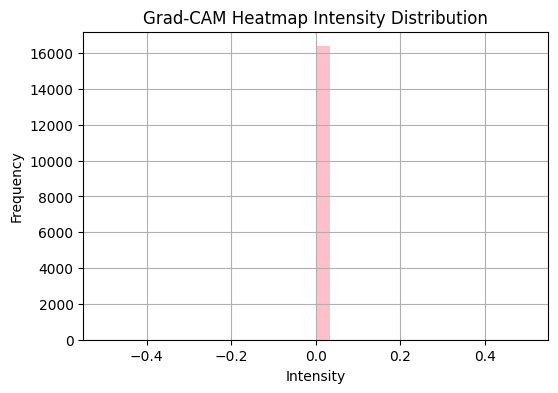

In [27]:
plt.figure(figsize=(6,4))
plt.hist(cam.ravel(), bins=30, color='pink')
plt.title('Grad-CAM Heatmap Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


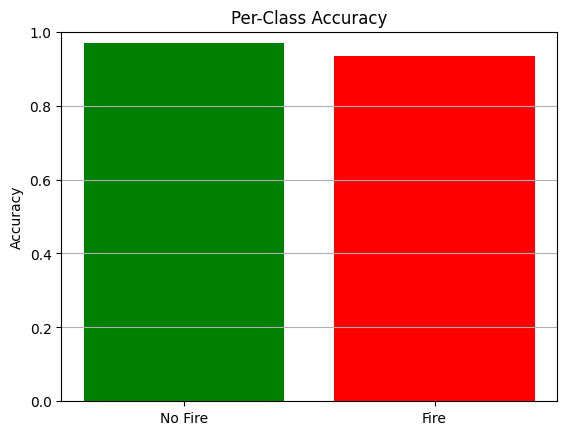

In [28]:
from sklearn.metrics import accuracy_score

fire_indices = np.where(y_true == 1)[0]
nofire_indices = np.where(y_true == 0)[0]

fire_acc = accuracy_score(y_true[fire_indices], y_pred[fire_indices])
nofire_acc = accuracy_score(y_true[nofire_indices], y_pred[nofire_indices])

plt.bar(['No Fire', 'Fire'], [nofire_acc, fire_acc], color=['green', 'red'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(True, axis='y')
plt.show()


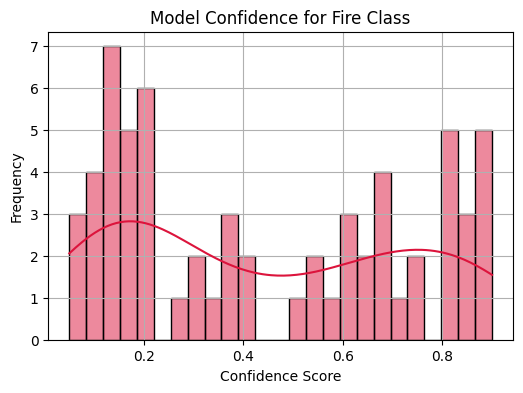

In [29]:
plt.figure(figsize=(6,4))
sns.histplot(y_pred_probs[:,1], bins=25, kde=True, color='crimson')
plt.title('Model Confidence for Fire Class')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


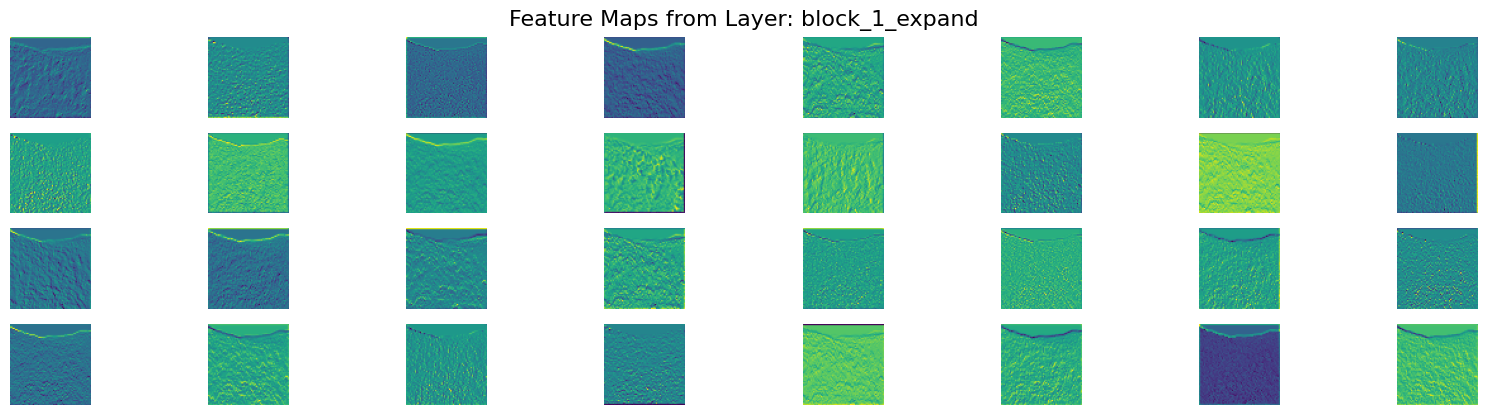

In [30]:
def visualize_feature_maps(model, img, layer_name='block_1_expand'):
    from tensorflow.keras.models import Model

    img_input = np.expand_dims(img, axis=0)
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = intermediate_model.predict(img_input)

    num_filters = feature_maps.shape[-1]
    cols = 8
    rows = num_filters // cols

    plt.figure(figsize=(16, 12))
    for i in range(min(32, num_filters)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature Maps from Layer: {layer_name}", fontsize=16)
    plt.tight_layout()
    plt.savefig('../../static/charts/feature_map.png')
    plt.show()

# Usage
visualize_feature_maps(model, sample_img)


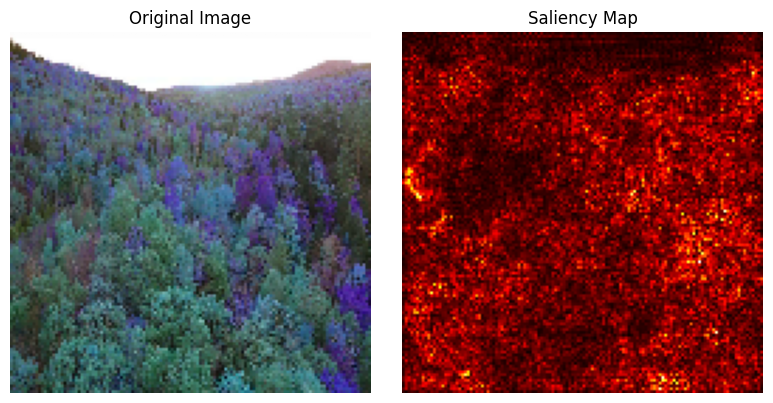

In [31]:
def compute_saliency_map(model, img):
    img_input = tf.convert_to_tensor(np.expand_dims(img, axis=0))
    with tf.GradientTape() as tape:
        tape.watch(img_input)
        preds = model(img_input)
        top_class = tf.argmax(preds[0])
        loss = preds[:, top_class]

    grads = tape.gradient(loss, img_input)[0]
    saliency = np.max(np.abs(grads), axis=-1)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../../static/charts/saliency_map.png')
    plt.show()

# Usage
compute_saliency_map(model, sample_img)


In [32]:
def save_saliency_map(img, saliency, filename="static/charts/saliency_map.png"):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


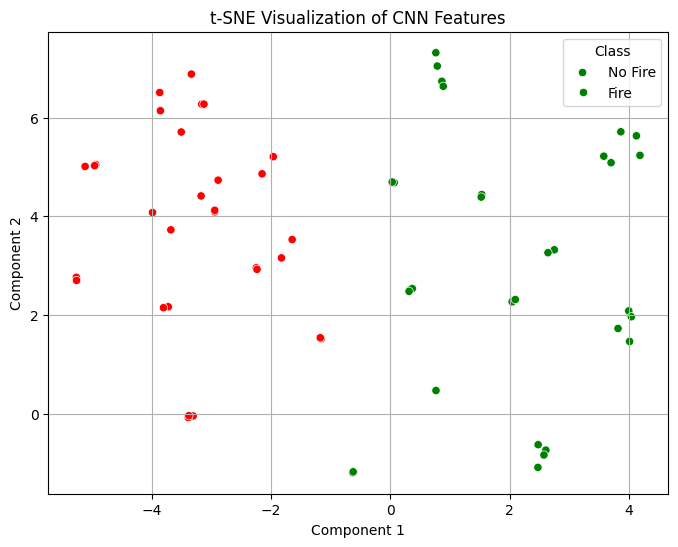

In [33]:
from sklearn.manifold import TSNE

# Get intermediate layer outputs
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)
features = intermediate_layer_model.predict(X_test)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=np.argmax(y_test, axis=1), palette=['green', 'red'])
plt.title("t-SNE Visualization of CNN Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Class', labels=['No Fire', 'Fire'])
plt.grid(True)
plt.savefig('../../static/charts/tsne.png')
plt.show()


In [34]:
def save_tsne(tsne_results, y_true, filename="static/charts/tsne.png"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=y_true, palette=['green', 'red'])
    plt.title("t-SNE Visualization of CNN Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title='Class', labels=['No Fire', 'Fire'])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

c:\Users\91877\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


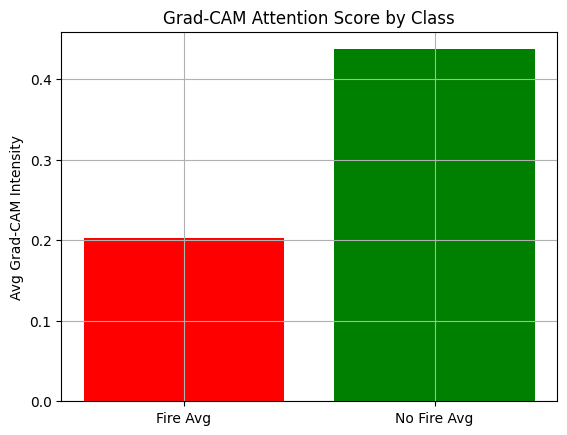

In [35]:
def gradcam_attention_score(video_path):
    frames = extract_frames(video_path, max_frames=FRAMES_PER_VIDEO)
    total_score = 0
    for frame in frames:
        cam = get_grad_cam(frame, model)
        total_score += np.mean(cam)
    return total_score / len(frames)

fire_scores = []
nofire_scores = []

for file in os.listdir(FIRE_DIR)[:3]:
    if file.endswith(".mp4"):
        score = gradcam_attention_score(os.path.join(FIRE_DIR, file))
        fire_scores.append(score)

for file in os.listdir(NOFIRE_DIR)[:3]:
    if file.endswith(".mp4"):
        score = gradcam_attention_score(os.path.join(NOFIRE_DIR, file))
        nofire_scores.append(score)

plt.bar(['Fire Avg', 'No Fire Avg'], [np.mean(fire_scores), np.mean(nofire_scores)], color=['red', 'green'])
plt.ylabel("Avg Grad-CAM Intensity")
plt.title("Grad-CAM Attention Score by Class")
plt.grid(True)
plt.show()


In [36]:
# Calculate class counts
counts = [np.sum(y == 0), np.sum(y == 1)]  # [No Fire, Fire]

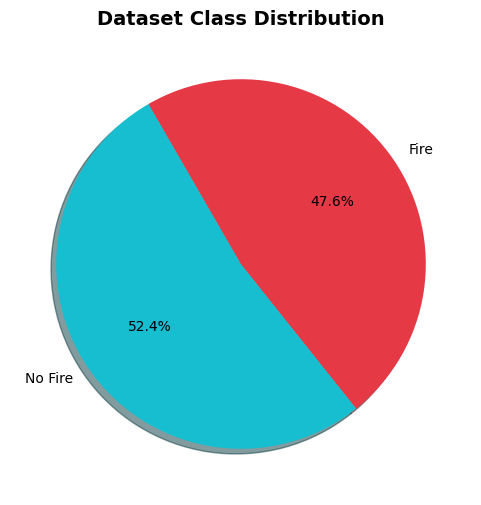

In [37]:
plt.figure(figsize=(6,6))
plt.pie(counts, labels=['No Fire', 'Fire'], autopct='%1.1f%%',
        colors=['#17becf', '#e63946'], startangle=120, shadow=True)
plt.title("Dataset Class Distribution", fontsize=14, fontweight='bold')
plt.show()


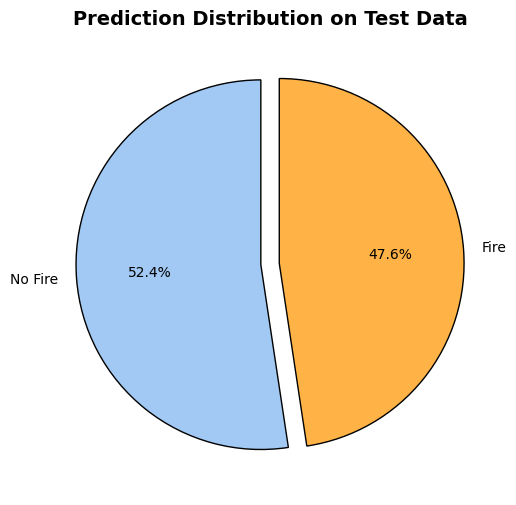

In [38]:
plt.figure(figsize=(6,6))
plt.pie(counts, labels=['No Fire', 'Fire'], autopct='%1.1f%%',
        colors=['#a1c9f4', '#ffb347'], startangle=90, 
        explode=(0.05,0.05), wedgeprops={'edgecolor':'black'})
plt.title("Prediction Distribution on Test Data", fontsize=14, fontweight='bold')
plt.show()


In [39]:
times = history.history.get('time_per_epoch', None)
if times:
    plt.plot(range(1, len(times)+1), times, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")
    plt.title("Training Time per Epoch")
    plt.grid(True)
    plt.show()


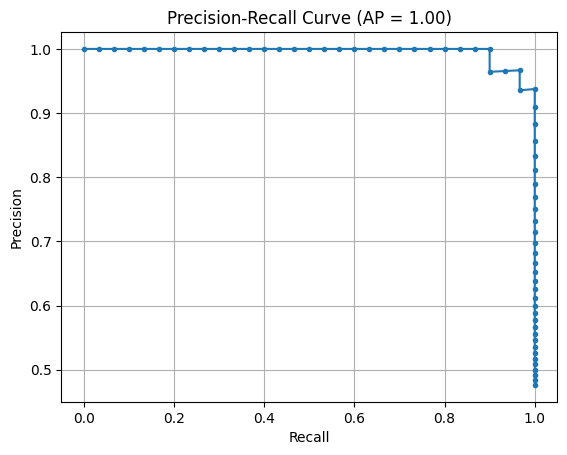

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(y_test[:,1], y_pred_probs[:,1])
ap = average_precision_score(y_test[:,1], y_pred_probs[:,1])

plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


In [41]:
import time
start = time.time()
predict_video(video_path)
print(f"⏱ Prediction Time: {time.time()-start:.2f} sec")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Prediction: 🔥 FIRE ([0.14710906 0.85289097])
⏱ Prediction Time: 2.64 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Prediction: 🔥 FIRE ([0.14710906 0.85289097])
⏱ Prediction Time: 2.64 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Prediction: 🔥 FIRE ([0.14710906 0.85289097])
⏱ Prediction Time: 2.64 sec


In [42]:
import json

# Save the history.history dictionary to a JSON file
with open('history.json', 'w') as f:
    json.dump(history.history, f)